# ChemCPA experiments

Experiment with ChemCPA for the following settings:
1. Hetzel et al. (2022)
    1. Inference (reference: chemCPA_Figure_2_*.ipynb)
        1. We will be using RDKit as molecule encoder. 
        2. Cell lines will be only ["A549", "K562", "MCF7"]
    2. Training (reference: `experiments_run.py`)
3. Our tx dataset
    1. Inference
    2. Training

In [ ]:
import os, sys, pickle
from typing import Optional
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedGroupKFold

import torch
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch_geometric.utils import is_undirected, structured_negative_sampling

import matplotlib
# from umap import UMAP
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
from pathlib import Path
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from novelddi.chemcpa.chemcpa_utils import load_config, load_dataset, load_smiles, load_model, compute_drug_embeddings, compute_pred, compute_pred_ctrl
from novelddi.chemcpa.chemCPA.data import load_dataset_splits
from novelddi.chemcpa.chemCPA.paths import FIGURE_DIR, ROOT

BASE_DIR = "/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/"
TX_DATA_DIR = BASE_DIR + "raw_data/transcriptomics_signature/"
KG_DATA_DIR = BASE_DIR + "PrimeKG/"
OUTPUT_DIR = BASE_DIR + "processed_data/"
VIEW_OUTPUT_DIR = OUTPUT_DIR + "views_features_new/"

## Shared gene sci-plex 3 dataset in Hetzel et al. (2022) [Deprecated]

Notes:

- JSON config to use: `$BASE_DIR/model_weights/chemCPA/checkpoints/finetuning_num_genes.json`
- Model checkpoint dir: `$BASE_DIR/model_weights/chemCPA/checkpoints/chemCPA_models/`

In [2]:
# RDKit
model_hash_pretrained = "27b401db1845eea26c102fb614df9c33" # Fine-tuned
model_hash_scratch = "51b81b77079c1060aedb0ee2259008ca" # Non-pretrained 

### Inference

In [3]:
import json
with open('/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_weights/chemCPA/checkpoints/finetuning_num_genes.json', 'rb') as f:
    configs = json.load(f)

In [4]:
config = configs[1]['config']  # pretrained
# config = configs[3]['config']  # from scratch

In [5]:
# config = load_config(seml_collection, model_hash_pretrained)

config["dataset"]["data_params"]["dataset_path"] = Path('/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_weights/chemCPA/datasets/sciplex_complete_middle_subset_lincs_genes.h5ad')

dataset, key_dict = load_dataset(config)
config['dataset']['n_vars'] = dataset.n_vars

In [6]:
dataset.n_vars

977

In [ ]:
canon_smiles_unique_sorted, smiles_to_pathway_map, smiles_to_drug_map = load_smiles(config, dataset, key_dict, True)

In [ ]:
key_dict

Get list of drugs that are ood in `ood_drugs`

In [10]:
ood_drugs = dataset.obs.condition[dataset.obs[config["dataset"]["data_params"]["split_key"]].isin(['ood'])].unique().to_list()
ood_drugs

['Hesperadin',
 'CUDC-101',
 'Raltitrexed',
 'Trametinib',
 'Dacinostat',
 'CUDC-907',
 'Pirarubicin',
 'Tanespimycin',
 'Givinostat']

Dataset splits

In [11]:
config['dataset']['data_params']

{'covariate_keys': 'cell_type',
 'dataset_path': PosixPath('/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_weights/chemCPA/datasets/sciplex_complete_middle_subset_lincs_genes.h5ad'),
 'degs_key': 'lincs_DEGs',
 'dose_key': 'dose',
 'pert_category': 'cov_drug_dose_name',
 'perturbation_key': 'condition',
 'smiles_key': 'SMILES',
 'split_key': 'split_ood_finetuning',
 'use_drugs_idx': True}

In [12]:
data_params = config['dataset']['data_params']
datasets = load_dataset_splits(**data_params, return_dataset=False)

In [13]:
dosages = [1e1,1e2,1e3,1e4]
cell_lines = ["A549", "K562", "MCF7"]

pretrained model

In [14]:
# config = load_config(seml_collection, model_hash_pretrained)
assert config["dataset"]["data_params"]["use_drugs_idx"]
assert config["model"]["additional_params"]["doser_type"] == "amortized"
config["config_hash"] = model_hash_pretrained
# config['model']['pretrained_model_path'] = '/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_weights/chemCPA/checkpoints/chemCPA_models/'

config['dataset']['n_vars'] = dataset.n_vars
config["model"]["embedding"]["directory"] = ROOT / 'embeddings/'

model_pretrained, embedding_pretrained = load_model(config, canon_smiles_unique_sorted)

In [15]:
cell_lines = ["A549", "K562", "MCF7"]
# cell_lines = ["A549", "K562", "MCF7", "PC3"]

In [16]:
datasets['test_control'].genes

tensor([[0.1325, 0.0000, 0.6890,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2168, 0.0000, 0.5459,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.3469, 0.0000, 0.6039,  ..., 0.6039, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4202,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [17]:
datasets['ood'].pert_categories

array(['A549_CUDC-101_0.1', 'K562_Hesperadin_0.001',
       'MCF7_Dacinostat_1.0', ..., 'MCF7_Raltitrexed_0.01',
       'MCF7_CUDC-101_1.0', 'K562_CUDC-101_0.1'], dtype=object)

In [17]:
# predictions = compute_pred(
#     model_pretrained, 
#     datasets['ood'], 
#     genes_control=datasets['test_control'].genes, 
#     dosages=dosages,
#     cell_lines=cell_lines,
#     # use_DEGs=False,
#     verbose=False,
# )

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

In [19]:
import torch
from tqdm import tqdm
from novelddi.chemcpa.chemCPA.train import bool2idx, compute_prediction, repeat_n

# def compute_pred
model = model_pretrained
dataset = datasets['ood']
dosages = dosages
cell_lines = cell_lines
# genes_control = datasets['test_control'].genes
genes_control = None  # we want the prediction to make use of the tx data we have rather than doing prediction solely from molecular structure encodings and basal state encodings
verbose = False

# dataset.pert_categories contains: 'celltype_perturbation_dose' info
pert_categories_index = pd.Index(dataset.pert_categories, dtype="category")

allowed_cell_lines = []

cl_dict = {
    torch.Tensor([1, 0, 0]): "A549",
    torch.Tensor([0, 1, 0]): "K562",
    torch.Tensor([0, 0, 1]): "MCF7",
}

if cell_lines is None:
    cell_lines = ["A549", "K562", "MCF7"]

print(cell_lines)

predictions_dict = {}


for cell_drug_dose_comb, category_count in tqdm(
    zip(*np.unique(dataset.pert_categories, return_counts=True))
):
    if dataset.perturbation_key is None:
        break

    # estimate metrics only for reasonably-sized drug/cell-type combos
    if category_count <= 5:
        continue

    # doesn't make sense to evaluate DMSO (=control) as a perturbation
    if (
        "dmso" in cell_drug_dose_comb.lower()
        or "control" in cell_drug_dose_comb.lower()
    ):
        continue
    
    # dataset.var_names is the list of gene names

    bool_category = pert_categories_index.get_loc(cell_drug_dose_comb)
    idx_all = bool2idx(bool_category)
    idx = idx_all[0]
    y_true = dataset.genes[idx_all, :].to(device="cuda")

    # cov_name = cell_drug_dose_comb.split("_")[0]
    # cond = dataset_ctrl.covariate_names["cell_type"] == cov_name
    # genes_control = dataset_ctrl.genes[cond]
    
    if genes_control is None:
        n_obs = y_true.size(0)
    else:
        assert isinstance(genes_control, torch.Tensor)
        n_obs = genes_control.size(0)
    
    emb_covs = [repeat_n(cov[idx], n_obs) for cov in dataset.covariates]  # cell line indicator * n_obs

    if dataset.dosages[idx] not in dosages:
        continue
    
    # stop = False
    # for tensor, cl in cl_dict.items():
    #     if (tensor == dataset.covariates[0][idx]).all():
    #         if cl not in cell_lines:
    #             stop = True
    # if stop:
    #     continue

    if dataset.use_drugs_idx:
        emb_drugs = (
            repeat_n(dataset.drugs_idx[idx], n_obs).squeeze(),
            repeat_n(dataset.dosages[idx], n_obs).squeeze(),
        )
    else:
        raise ValueError
        # emb_drugs = repeat_n(dataset.drugs[idx], n_obs)

    # copies just the needed genes to GPU
    # Could try moving the whole genes tensor to GPU once for further speedups (but more memory problems)
    
    if genes_control is None:
        # print("Predicting AE alike.")
        mean_pred, _ = compute_prediction(
            model,
            y_true,
            emb_drugs,
            emb_covs,
        )
    else:
        raise ValueError
        # print("Predicting counterfactuals.")
        # mean_pred, _ = compute_prediction(
        #     model,
        #     genes_control,
        #     emb_drugs,
        #     emb_covs,
        # )

    y_pred = mean_pred.mean(0)
    y_true = y_true.mean(0)

    predictions_dict[cell_drug_dose_comb] = [y_true, y_pred]

['A549', 'K562', 'MCF7']


108it [00:06, 15.70it/s]


In [26]:
model

ComPert(
  (encoder): MLP(
    (network): Sequential(
      (0): Linear(in_features=977, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=256, out_features=256, bias=True)
      (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Linear(in_features=256, out_features=32, bias=True)
    )
  )
  (decoder): MLP(
    (relu): ReLU()
    (network): Sequential(
      (0): Linear(in_features=32, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum

In [25]:
adata = sc.read('/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_weights/chemCPA/datasets/lincs_full_smiles.h5ad')

In [ ]:
adata.obs[adata.obs['control'] == 1].pert_id

index
ASG001_MCF7_6H_X2_B7_DUO52HI53LO:A13-1    DMSO
ASG001_MCF7_6H_X2_B7_DUO52HI53LO:D13-1    DMSO
ASG001_MCF7_6H_X2_B7_DUO52HI53LO:F13-1    DMSO
ASG001_MCF7_6H_X2_B7_DUO52HI53LO:G13-1    DMSO
ASG001_MCF7_6H_X2_B7_DUO52HI53LO:H13-1    DMSO
                                          ... 
ERG017_VCAP_24H_X3.A2_B12:N24-1           DMSO
ERG017_VCAP_24H_X3.A2_B12:O01-1           DMSO
ERG017_VCAP_24H_X3.A2_B12:O21-1           DMSO
ERG017_VCAP_24H_X3.A2_B12:P21-1           DMSO
ERG017_VCAP_24H_X3.A2_B12:P22-1           DMSO
Name: pert_id, Length: 3836, dtype: category
Categories (17775, object): ['BRD-A00100033', 'BRD-A00150179', 'BRD-A00267231', 'BRD-A00420644', ..., 'BRD-M98649031', 'BRD-U88459701', 'BRD-U94846492', 'DMSO']

In [54]:
from sklearn.preprocessing import StandardScaler
temp = adata.X.A
StandardScaler().fit_transform(temp)

array([[ 0.06613994, -0.634553  ,  1.8683908 , ..., -0.26807085,
        -0.7298963 , -1.2507262 ],
       [ 0.07670635, -0.4542364 ,  1.6484607 , ..., -0.28997886,
        -0.7626416 , -1.3330313 ],
       [ 0.1860766 , -0.5475731 ,  1.4088849 , ..., -0.1165553 ,
        -0.67706096, -1.298995  ],
       ...,
       [-0.2255056 , -0.81088036,  1.2256038 , ...,  1.4854624 ,
         1.5110743 , -0.59780204],
       [-0.33033726, -0.7934324 , -0.30602834, ...,  1.6625254 ,
         1.1813704 , -0.63754797],
       [-0.04259769, -0.7219545 ,  0.48685154, ...,  1.5578392 ,
         0.91444   ,  0.03909715]], dtype=float32)

## Custom Tx dataset

It seems the L1000 dataset used in Hetzel et al. (2022) was **not** normalized. In comparison, our Tx dataset (CMap 2020) is normalized. Nevertheless, we still start from the weights pretrained from L1000.

### Generate RDKit embeddings

Note: Since we normalize the RDKit embeddings for each feature dimension, the RDKit embedding distribution during pretraining (Tx adapting compounds) is different from the one during contrastive pretraining and DDI finetuning (curated compounds).

In [94]:
# smiles_df = pd.read_csv(EMBEDDING_DIR / f'{dataset_name}.smiles')
# smiles_list = smiles_df['smiles'].values

dataset_name = 'all'

# For curated compounds
drug_metadata = pd.read_pickle(VIEW_OUTPUT_DIR+'combined_metadata_ddi.pkl')
drug_metadata['view_tx'] = (drug_metadata[[col for col in drug_metadata.columns if col.startswith('view_tx_')]].sum(axis=1) >= 1).astype(int)
smiles_list_comb = drug_metadata['canonical_smiles'].values

# For TX pretraining
tx_cp_metadata_for_adapting = pd.read_pickle(VIEW_OUTPUT_DIR+'tx/tx_cp_metadata_for_adapting.pkl')
assert np.all(np.sort(tx_cp_metadata_for_adapting['canonical_smiles'].unique()) == tx_cp_metadata_for_adapting['canonical_smiles'].unique())
smiles_list_adapting = tx_cp_metadata_for_adapting['canonical_smiles'].unique()

smiles_list = np.unique(np.concatenate([smiles_list_comb, smiles_list_adapting]))

In [95]:
print(f'Number of smiles strings: {len(smiles_list)}')

Number of smiles strings: 22398


In [83]:
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
generator = MakeGenerator(("RDKit2D",))
for name, numpy_type in generator.GetColumns():
    print(f"{name}({numpy_type.__name__})")

RDKit2D_calculated(bool)
BalabanJ(float64)
BertzCT(float64)
Chi0(float64)
Chi0n(float64)
Chi0v(float64)
Chi1(float64)
Chi1n(float64)
Chi1v(float64)
Chi2n(float64)
Chi2v(float64)
Chi3n(float64)
Chi3v(float64)
Chi4n(float64)
Chi4v(float64)
EState_VSA1(float64)
EState_VSA10(float64)
EState_VSA11(float64)
EState_VSA2(float64)
EState_VSA3(float64)
EState_VSA4(float64)
EState_VSA5(float64)
EState_VSA6(float64)
EState_VSA7(float64)
EState_VSA8(float64)
EState_VSA9(float64)
ExactMolWt(float64)
FpDensityMorgan1(float64)
FpDensityMorgan2(float64)
FpDensityMorgan3(float64)
FractionCSP3(float64)
HallKierAlpha(float64)
HeavyAtomCount(float64)
HeavyAtomMolWt(float64)
Ipc(float64)
Kappa1(float64)
Kappa2(float64)
Kappa3(float64)
LabuteASA(float64)
MaxAbsEStateIndex(float64)
MaxAbsPartialCharge(float64)
MaxEStateIndex(float64)
MaxPartialCharge(float64)
MinAbsEStateIndex(float64)
MinAbsPartialCharge(float64)
MinEStateIndex(float64)
MinPartialCharge(float64)
MolLogP(float64)
MolMR(float64)
MolWt(float64)

In [84]:
n_jobs = 4
data = Parallel(n_jobs=n_jobs)(delayed(generator.process)(smiles) for smiles in tqdm(smiles_list, position=0, leave=True) )

  0%|          | 0/22398 [00:00<?, ?it/s]

[17:35:22] Unusual charge on atom 42 number of radical electrons set to zero
[17:35:22] Unusual charge on atom 42 number of radical electrons set to zero
[17:36:29] WARNING: not removing hydrogen atom without neighbors
[17:36:29] WARNING: not removing hydrogen atom without neighbors
[17:36:29] WARNING: not removing hydrogen atom without neighbors
[17:36:29] WARNING: not removing hydrogen atom without neighbors


In [85]:
embedding = np.array(data)
embedding.shape

(22398, 201)

Check for `nans`

In [86]:
drug_idx, feature_idx = np.where(np.isnan(embedding))
print(f'drug_idx:\n {drug_idx}')
print(f'feature_idx:\n {feature_idx}')

drug_idx:
 [  342   342   342   342   511   511   511   511   677   677   677   677
   696   696   696   696   697   697   697   697   698   698   698   698
   699   699   699   699   700   700   700   700   701   701   701   701
   702   702   702   702   703   703   703   703  1063  1063  1063  1063
  1064  1064  1064  1064  1208  1208  1208  1208  1306  1306  1306  1306
  1307  1307  1307  1307  2804  2804  2804  2804  2924  2924  2924  2924
  3112  3112  3112  3112  3129  3129  3129  3129  3130  3130  3130  3130
  3131  3131  3131  3131  3134  3134  3134  3134  3135  3135  3135  3135
  3152  3152  3152  3152  3182  3182  3182  3182  3763  3763  3763  3763
  4026  4026  4026  4026  4530  4530  4530  4530  4547  4547  4547  4547
  5765  5765  5765  5765  5766  5766  5766  5766  6100  6100  6100  6100
  6127  6127  6127  6127  6145  6145  6145  6145  7344  7344  7344  7344
  7566  7566  7566  7566  8106  8106  8106  8106  8107  8107  8107  8107
 11255 11255 11255 11255 11256 11256 112

Check for `infs` and add to idx lists

In [87]:
drug_idx_infs, feature_idx_infs = np.where(np.isinf(embedding))

drug_idx = np.concatenate((drug_idx, drug_idx_infs))
feature_idx = np.concatenate((feature_idx, feature_idx_infs))

Features that have these invalid values:

In [88]:
np.array(generator.GetColumns())[np.unique(feature_idx)]

array([['MaxAbsPartialCharge', <class 'numpy.float64'>],
       ['MaxPartialCharge', <class 'numpy.float64'>],
       ['MinAbsPartialCharge', <class 'numpy.float64'>],
       ['MinPartialCharge', <class 'numpy.float64'>]], dtype=object)

Set values to `0`

In [89]:
embedding[drug_idx, feature_idx] 

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [90]:
embedding[drug_idx, feature_idx] = 0

Save

In [91]:
import pandas as pd

df = pd.DataFrame(data=embedding,index=smiles_list,columns=[f'latent_{i}' for i in range(embedding.shape[1])]) 

# Drop first feature from generator (RDKit2D_calculated)
df.drop(columns=['latent_0'], inplace=True)

# Drop columns with 0 standard deviation
threshold = 1e-4
columns=[f'latent_{idx+1}' for idx in np.where(df.std() <= threshold)[0]]
print(f'Deleting columns with std <= {threshold}: {columns}')
df.drop(columns=[f'latent_{idx+1}' for idx in np.where(df.std() <= threshold)[0]], inplace=True)

Deleting columns with std <= 0.0001: ['latent_90', 'latent_103', 'latent_187']


/home/yeh803/.conda/envs/primekg/lib/python3.8/site-packages/pandas/core/nanops.py:1007: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


Check that correct columns were deleted: 

In [92]:
np.where(df.std() <= threshold)

/home/yeh803/.conda/envs/primekg/lib/python3.8/site-packages/pandas/core/nanops.py:1007: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


(array([], dtype=int64),)

Normalise dataframe

In [93]:
normalized_df = (df - df.mean()) / df.std()

Check destination folder

In [96]:
model_name = 'rdkit2D'
directory = VIEW_OUTPUT_DIR + 'tx/embeddings/'
os.makedirs(directory, exist_ok=True)

fname = f'{model_name}_embeddings_all_all_normalized.parquet'
fname_comb = f'{model_name}_embeddings_combined_all_normalized.parquet'
fname_adapting = f'{model_name}_embeddings_adapting_all_normalized.parquet'

Save normalised version

In [98]:
normalized_df.to_parquet(directory + fname)
normalized_df.loc[smiles_list_comb].to_parquet(directory + fname_comb)
normalized_df.loc[smiles_list_adapting].to_parquet(directory + fname_adapting)

### Training

In [2]:
import torch, os
import pandas as pd
import numpy as np
from pathlib import Path
from pprint import pprint

from seml.config import generate_configs, read_config

from novelddi.chemcpa.chemCPA.experiments_run import TxAdaptingExperimentWrapper


In [2]:
exp = TxAdaptingExperimentWrapper(init_all=False)

assert os.path.exists(
    "../../configs/chemcpa/chemcpa_tx_adapting_configs.yaml"
), "config file not found"
seml_config, slurm_config, experiment_config = read_config(
    "../../configs/chemcpa/chemcpa_tx_adapting_configs.yaml"
)
# we take the first config generated
configs = generate_configs(experiment_config)
if len(configs) > 1:
    raise Exception("More than one config generated from the yaml file")
args = configs[0]
# pprint(args)

exp.init_dataset(**args["dataset"])
exp.init_drug_embedding(embedding=args["model"]["embedding"])
exp.init_model(
    hparams=args["model"]["hparams"],
    additional_params=args["model"]["additional_params"],
    load_pretrained=args["model"]["load_pretrained"],
    append_ae_layer=args["model"]["append_ae_layer"],
    pretrained_model_path=args["model"]["pretrained_model_path"],
    pretrained_model_ckpt=args["model"]["pretrained_model_ckpt"],
    use_drugs=args["model"]["use_drugs"]
)
exp.update_datasets()

2023-09-01 10:17:08 (INFO): Starting to read in data from /n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/processed_data/views_features_new/tx/
...
2023-09-01 10:25:30 (INFO): Finished data loading.


In [3]:
res = exp.train(**args["training"])

CWD: /home/yeh803/workspace/DDI/NovelDDI/configs/chemcpa
Save dir: /n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_output/pretrain/adapting/tx/checkpoints/


2023-09-01 10:25:37 (INFO): 
{   'epoch': 0,
    'loss_adv_covariates': 2.7960239357418484,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.7798638025919596,
    'penalty_adv_covariates': 0.02200277220043871,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:25:40 (INFO): 
{   'epoch': 1,
    'loss_adv_covariates': 2.6848738193511963,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.5799427562289767,
    'penalty_adv_covariates': 0.005120067877901925,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:25:44 (INFO): 
{   'epoch': 2,
    'loss_adv_covariates': 2.6573961204952665,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.5540830373764039,
    'penalty_adv_covariates': 0.00204976134830051,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:25:48 (INFO): 
{   'epoch': 3,
    'loss_adv_covariates': 2.609613969590929,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.542301188574897,
    'penalty_adv_covariates': 0.0011268312266717354,
    'penalty_adv_drugs': 0.0}
2023-09-01 


Took 0.0 min for evaluation.



2023-09-01 10:26:56 (INFO): 
{   'epoch': 21,
    'loss_adv_covariates': 2.591219917933146,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.5028640263610415,
    'penalty_adv_covariates': 0.0002488510502088401,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:26:59 (INFO): 
{   'epoch': 22,
    'loss_adv_covariates': 2.5954451296064587,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.5003348377015856,
    'penalty_adv_covariates': 0.00039265565832869874,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:27:03 (INFO): 
{   'epoch': 23,
    'loss_adv_covariates': 2.5960477405124243,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.5037578894032373,
    'penalty_adv_covariates': 0.00019713253778819409,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:27:07 (INFO): 
{   'epoch': 24,
    'loss_adv_covariates': 2.53621252907647,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4998082717259725,
    'penalty_adv_covariates': 8.082221627571723e-05,
    'penalty_adv_drugs': 0.0}
2


Took 0.0 min for evaluation.



2023-09-01 10:28:12 (INFO): 
{   'epoch': 41,
    'loss_adv_covariates': 2.5672095192803277,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.490958034992218,
    'penalty_adv_covariates': 0.00021857520138534407,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:28:16 (INFO): 
{   'epoch': 42,
    'loss_adv_covariates': 2.551557641559177,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.48839934137132435,
    'penalty_adv_covariates': 0.0001155725289006821,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:28:19 (INFO): 
{   'epoch': 43,
    'loss_adv_covariates': 2.549307123819987,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.48573509189817643,
    'penalty_adv_covariates': 8.938821976900928e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:28:23 (INFO): 
{   'epoch': 44,
    'loss_adv_covariates': 2.550608592563205,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4862995127836863,
    'penalty_adv_covariates': 9.873551413572082e-05,
    'penalty_adv_drugs': 0.0}
2


Took 0.0 min for evaluation.



2023-09-01 10:29:34 (INFO): 
{   'epoch': 61,
    'loss_adv_covariates': 2.5521936522589788,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4767078247335222,
    'penalty_adv_covariates': 0.00021549760066490205,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:29:38 (INFO): 
{   'epoch': 62,
    'loss_adv_covariates': 2.552662107679579,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.47671694689326816,
    'penalty_adv_covariates': 0.00020679318371953235,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:29:42 (INFO): 
{   'epoch': 63,
    'loss_adv_covariates': 2.5491503132714164,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4757465581099192,
    'penalty_adv_covariates': 0.00017155531354041563,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:29:45 (INFO): 
{   'epoch': 64,
    'loss_adv_covariates': 2.5495348665449353,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.47528557380040487,
    'penalty_adv_covariates': 0.00021184369559503263,
    'penalty_adv_drugs': 


Took 0.0 min for evaluation.



2023-09-01 10:30:52 (INFO): 
{   'epoch': 81,
    'loss_adv_covariates': 2.5550015290578205,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4776189115312364,
    'penalty_adv_covariates': 0.0004337918336710168,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:30:56 (INFO): 
{   'epoch': 82,
    'loss_adv_covariates': 2.554756106270684,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4751250359747145,
    'penalty_adv_covariates': 0.00011979207564662728,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:31:00 (INFO): 
{   'epoch': 83,
    'loss_adv_covariates': 2.551751989788479,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.47407484783066645,
    'penalty_adv_covariates': 2.7837439443424552e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:31:03 (INFO): 
{   'epoch': 84,
    'loss_adv_covariates': 2.5526946915520563,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4728435582584805,
    'penalty_adv_covariates': 1.292743189777765e-05,
    'penalty_adv_drugs': 0.0}


Took 0.0 min for evaluation.



2023-09-01 10:32:08 (INFO): 
{   'epoch': 101,
    'loss_adv_covariates': 2.5453715218438044,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4697847757074568,
    'penalty_adv_covariates': 4.3609852339917174e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:32:12 (INFO): 
{   'epoch': 102,
    'loss_adv_covariates': 2.5392881817287867,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46954689423243207,
    'penalty_adv_covariates': 4.6508944392876905e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:32:16 (INFO): 
{   'epoch': 103,
    'loss_adv_covariates': 2.5403983063167996,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4687097801102532,
    'penalty_adv_covariates': 4.296285333111882e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:32:20 (INFO): 
{   'epoch': 104,
    'loss_adv_covariates': 2.547484869427151,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4686481793721517,
    'penalty_adv_covariates': 3.8939776034870494e-05,
    'penalty_adv_drugs'


Took 0.0 min for evaluation.



2023-09-01 10:33:25 (INFO): 
{   'epoch': 121,
    'loss_adv_covariates': 2.5456979327731664,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4671614117092556,
    'penalty_adv_covariates': 5.412389307619176e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:33:29 (INFO): 
{   'epoch': 122,
    'loss_adv_covariates': 2.550910319222344,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46752978298399184,
    'penalty_adv_covariates': 7.808202062733471e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:33:33 (INFO): 
{   'epoch': 123,
    'loss_adv_covariates': 2.552002673678928,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4680587238735623,
    'penalty_adv_covariates': 8.779974628446831e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:33:37 (INFO): 
{   'epoch': 124,
    'loss_adv_covariates': 2.5488361729515923,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4668134444289737,
    'penalty_adv_covariates': 8.576138837573429e-05,
    'penalty_adv_drugs': 0.


Took 0.0 min for evaluation.



2023-09-01 10:34:45 (INFO): 
{   'epoch': 141,
    'loss_adv_covariates': 2.551498481962416,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4664889090591007,
    'penalty_adv_covariates': 8.159765566233546e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:34:49 (INFO): 
{   'epoch': 142,
    'loss_adv_covariates': 2.553961748547024,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4650114172034793,
    'penalty_adv_covariates': 4.086925990931276e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:34:53 (INFO): 
{   'epoch': 143,
    'loss_adv_covariates': 2.5505717860327826,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46573450300428604,
    'penalty_adv_covariates': 3.814624716243189e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:34:57 (INFO): 
{   'epoch': 144,
    'loss_adv_covariates': 2.5469510396321615,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46846776141060725,
    'penalty_adv_covariates': 6.823409267882299e-05,
    'penalty_adv_drugs': 0


Took 0.0 min for evaluation.



2023-09-01 10:36:05 (INFO): 
{   'epoch': 161,
    'loss_adv_covariates': 2.550019709269206,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46187277634938556,
    'penalty_adv_covariates': 1.554861110990815e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:36:09 (INFO): 
{   'epoch': 162,
    'loss_adv_covariates': 2.5487642341189916,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4624997291300032,
    'penalty_adv_covariates': 1.7801568739944034e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:36:14 (INFO): 
{   'epoch': 163,
    'loss_adv_covariates': 2.54516364203559,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4620960712432861,
    'penalty_adv_covariates': 2.3085205773693613e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:36:18 (INFO): 
{   'epoch': 164,
    'loss_adv_covariates': 2.5442849424150253,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46139008932643466,
    'penalty_adv_covariates': 2.7665392958119305e-05,
    'penalty_adv_drugs':


Took 0.0 min for evaluation.



2023-09-01 10:37:27 (INFO): 
{   'epoch': 181,
    'loss_adv_covariates': 2.5476545492808023,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4612336344189114,
    'penalty_adv_covariates': 2.319596331087976e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:37:31 (INFO): 
{   'epoch': 182,
    'loss_adv_covariates': 2.545641231536865,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46061199638578626,
    'penalty_adv_covariates': 2.1219873451627792e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:37:35 (INFO): 
{   'epoch': 183,
    'loss_adv_covariates': 2.54506008360121,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.460439627038108,
    'penalty_adv_covariates': 2.1645907690981402e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:37:38 (INFO): 
{   'epoch': 184,
    'loss_adv_covariates': 2.5482968595292834,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4609920581181844,
    'penalty_adv_covariates': 2.584755897664258e-05,
    'penalty_adv_drugs': 0.


Took 0.0 min for evaluation.



2023-09-01 10:38:44 (INFO): 
{   'epoch': 201,
    'loss_adv_covariates': 2.5523872163560655,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4592636638217502,
    'penalty_adv_covariates': 1.8507539870269184e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:38:48 (INFO): 
{   'epoch': 202,
    'loss_adv_covariates': 2.5521702766418457,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4599762128459083,
    'penalty_adv_covariates': 1.841467358948042e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:38:52 (INFO): 
{   'epoch': 203,
    'loss_adv_covariates': 2.547683509190877,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45998035735554166,
    'penalty_adv_covariates': 2.0074163815782717e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:38:56 (INFO): 
{   'epoch': 204,
    'loss_adv_covariates': 2.545444032880995,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4597760101159414,
    'penalty_adv_covariates': 2.423297240360019e-05,
    'penalty_adv_drugs': 


Took 0.0 min for evaluation.



2023-09-01 10:40:06 (INFO): 
{   'epoch': 221,
    'loss_adv_covariates': 2.546402327219645,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4581784983476003,
    'penalty_adv_covariates': 5.913729934642712e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:40:10 (INFO): 
{   'epoch': 222,
    'loss_adv_covariates': 2.549414698282878,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4585235330793593,
    'penalty_adv_covariates': 6.428315326856035e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:40:14 (INFO): 
{   'epoch': 223,
    'loss_adv_covariates': 2.550355407926771,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4583525896072388,
    'penalty_adv_covariates': 6.955949906518476e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:40:18 (INFO): 
{   'epoch': 224,
    'loss_adv_covariates': 2.5513991355895995,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45878372258610195,
    'penalty_adv_covariates': 8.488605154626486e-05,
    'penalty_adv_drugs': 0.0


Took 0.0 min for evaluation.



2023-09-01 10:41:25 (INFO): 
{   'epoch': 241,
    'loss_adv_covariates': 2.5520056141747367,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4574425200621287,
    'penalty_adv_covariates': 6.435479703618007e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:41:29 (INFO): 
{   'epoch': 242,
    'loss_adv_covariates': 2.5593807379404705,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45752180152469213,
    'penalty_adv_covariates': 3.3536241810199704e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:41:33 (INFO): 
{   'epoch': 243,
    'loss_adv_covariates': 2.5532625145382353,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45715445412529837,
    'penalty_adv_covariates': 2.626249010467695e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:41:36 (INFO): 
{   'epoch': 244,
    'loss_adv_covariates': 2.5503238519032796,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45641995006137426,
    'penalty_adv_covariates': 4.454682267452073e-05,
    'penalty_adv_drugs


Took 0.0 min for evaluation.



2023-09-01 10:42:42 (INFO): 
{   'epoch': 261,
    'loss_adv_covariates': 2.55121111869812,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4570783621735043,
    'penalty_adv_covariates': 6.762378939634396e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:42:46 (INFO): 
{   'epoch': 262,
    'loss_adv_covariates': 2.5508939690060086,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4578657805919647,
    'penalty_adv_covariates': 6.866512283320642e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:42:50 (INFO): 
{   'epoch': 263,
    'loss_adv_covariates': 2.5506599055396184,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45725954042540656,
    'penalty_adv_covariates': 6.38112703907407e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:42:53 (INFO): 
{   'epoch': 264,
    'loss_adv_covariates': 2.550734938515557,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45730826722251045,
    'penalty_adv_covariates': 6.808355586448063e-05,
    'penalty_adv_drugs': 0.0


Took 0.0 min for evaluation.



2023-09-01 10:43:59 (INFO): 
{   'epoch': 281,
    'loss_adv_covariates': 2.5628276930914984,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4601591017511156,
    'penalty_adv_covariates': 0.00038223216672324473,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:44:03 (INFO): 
{   'epoch': 282,
    'loss_adv_covariates': 2.5545434792836508,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45999143918355306,
    'penalty_adv_covariates': 0.0005213526957150963,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:44:06 (INFO): 
{   'epoch': 283,
    'loss_adv_covariates': 2.553470034069485,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4603160500526428,
    'penalty_adv_covariates': 0.00047407403407204483,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:44:10 (INFO): 
{   'epoch': 284,
    'loss_adv_covariates': 2.5575724654727514,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46083510981665715,
    'penalty_adv_covariates': 0.00038034843229171303,
    'penalty_adv_drugs


Took 0.0 min for evaluation.



2023-09-01 10:45:16 (INFO): 
{   'epoch': 301,
    'loss_adv_covariates': 2.5536938084496392,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4591777119371626,
    'penalty_adv_covariates': 3.913955103295545e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:45:20 (INFO): 
{   'epoch': 302,
    'loss_adv_covariates': 2.5537295076582165,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4585824072360992,
    'penalty_adv_covariates': 4.147205812235673e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:45:23 (INFO): 
{   'epoch': 303,
    'loss_adv_covariates': 2.5527912510765924,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45867467257711625,
    'penalty_adv_covariates': 3.9606863639265714e-05,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:45:27 (INFO): 
{   'epoch': 304,
    'loss_adv_covariates': 2.552077849706014,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4589808689223395,
    'penalty_adv_covariates': 4.3574075324512605e-05,
    'penalty_adv_drugs':


Took 0.0 min for evaluation.



2023-09-01 10:46:32 (INFO): 
{   'epoch': 321,
    'loss_adv_covariates': 2.5554888142479792,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4591604934798347,
    'penalty_adv_covariates': 0.0001014080432166035,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:46:35 (INFO): 
{   'epoch': 322,
    'loss_adv_covariates': 2.5562486595577663,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45949265559514363,
    'penalty_adv_covariates': 0.00011208639383160819,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:46:39 (INFO): 
{   'epoch': 323,
    'loss_adv_covariates': 2.5555139117770724,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4589827603764004,
    'penalty_adv_covariates': 0.0001063376209155346,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:46:43 (INFO): 
{   'epoch': 324,
    'loss_adv_covariates': 2.556148237652249,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.45983405311902364,
    'penalty_adv_covariates': 0.00011312622939132981,
    'penalty_adv_drugs'


Took 0.0 min for evaluation.



2023-09-01 10:47:50 (INFO): 
{   'epoch': 341,
    'loss_adv_covariates': 2.572228659523858,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46037320295969647,
    'penalty_adv_covariates': 0.0005258155236434605,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:47:54 (INFO): 
{   'epoch': 342,
    'loss_adv_covariates': 2.573376539018419,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46039192080497743,
    'penalty_adv_covariates': 0.0005570584338986212,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:47:58 (INFO): 
{   'epoch': 343,
    'loss_adv_covariates': 2.572279442681207,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46074698236253525,
    'penalty_adv_covariates': 0.0005357359173811144,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:48:02 (INFO): 
{   'epoch': 344,
    'loss_adv_covariates': 2.571544122695923,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46118116312556795,
    'penalty_adv_covariates': 0.0005866673619796832,
    'penalty_adv_drugs': 0


Took 0.0 min for evaluation.



2023-09-01 10:49:17 (INFO): 
{   'epoch': 361,
    'loss_adv_covariates': 2.5715390894148085,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4610725237263574,
    'penalty_adv_covariates': 0.000816197165598472,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:49:22 (INFO): 
{   'epoch': 362,
    'loss_adv_covariates': 2.5714994960361057,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4602150665389167,
    'penalty_adv_covariates': 0.0008688639538983504,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:49:26 (INFO): 
{   'epoch': 363,
    'loss_adv_covariates': 2.5725292258792454,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46040238406923084,
    'penalty_adv_covariates': 0.0008513000664404697,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:49:31 (INFO): 
{   'epoch': 364,
    'loss_adv_covariates': 2.5717819743686254,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46035480234358045,
    'penalty_adv_covariates': 0.0009210388098532955,
    'penalty_adv_drugs': 


Took 0.0 min for evaluation.



2023-09-01 10:50:43 (INFO): 
{   'epoch': 381,
    'loss_adv_covariates': 2.573165962431166,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4626484215259552,
    'penalty_adv_covariates': 0.0010986151846332681,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:50:47 (INFO): 
{   'epoch': 382,
    'loss_adv_covariates': 2.5733504560258655,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4621972938378652,
    'penalty_adv_covariates': 0.001171346805575821,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:50:51 (INFO): 
{   'epoch': 383,
    'loss_adv_covariates': 2.5738828659057615,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46272778643502127,
    'penalty_adv_covariates': 0.0011779226466185518,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:50:56 (INFO): 
{   'epoch': 384,
    'loss_adv_covariates': 2.5745807117886015,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4619110001458062,
    'penalty_adv_covariates': 0.001242938560123245,
    'penalty_adv_drugs': 0.0


Took 0.0 min for evaluation.



2023-09-01 10:52:06 (INFO): 
{   'epoch': 401,
    'loss_adv_covariates': 2.5724408520592585,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4624075286918216,
    'penalty_adv_covariates': 0.001144091614211599,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:52:10 (INFO): 
{   'epoch': 402,
    'loss_adv_covariates': 2.5724624580807154,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4630081090662215,
    'penalty_adv_covariates': 0.0011733815384407837,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:52:14 (INFO): 
{   'epoch': 403,
    'loss_adv_covariates': 2.5716131687164308,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46267129513952465,
    'penalty_adv_covariates': 0.0011126051760382122,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:52:18 (INFO): 
{   'epoch': 404,
    'loss_adv_covariates': 2.571424372990926,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4628313905662961,
    'penalty_adv_covariates': 0.0011361460977544386,
    'penalty_adv_drugs': 0.


Took 0.0 min for evaluation.



2023-09-01 10:53:30 (INFO): 
{   'epoch': 421,
    'loss_adv_covariates': 2.580293533537123,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46246021588643393,
    'penalty_adv_covariates': 0.0008132063990665807,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:53:34 (INFO): 
{   'epoch': 422,
    'loss_adv_covariates': 2.5801290829976398,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4628110812769996,
    'penalty_adv_covariates': 0.0008635529886103339,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:53:39 (INFO): 
{   'epoch': 423,
    'loss_adv_covariates': 2.579867394765218,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4627067618899875,
    'penalty_adv_covariates': 0.0008061108231130574,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:53:43 (INFO): 
{   'epoch': 424,
    'loss_adv_covariates': 2.5814616468217637,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4627690772215525,
    'penalty_adv_covariates': 0.0008686615102407006,
    'penalty_adv_drugs': 0.


Took 0.0 min for evaluation.



2023-09-01 10:54:53 (INFO): 
{   'epoch': 441,
    'loss_adv_covariates': 2.58441375096639,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46301836570103966,
    'penalty_adv_covariates': 0.000989964596616725,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:54:57 (INFO): 
{   'epoch': 442,
    'loss_adv_covariates': 2.584996838039822,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.462999994887246,
    'penalty_adv_covariates': 0.0010470934910699725,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:55:01 (INFO): 
{   'epoch': 443,
    'loss_adv_covariates': 2.58393972714742,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46308630572424997,
    'penalty_adv_covariates': 0.0009871825446478195,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:55:06 (INFO): 
{   'epoch': 444,
    'loss_adv_covariates': 2.5835378328959147,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4627587212456597,
    'penalty_adv_covariates': 0.0010492235629094972,
    'penalty_adv_drugs': 0.0}
2


Took 0.0 min for evaluation.



2023-09-01 10:56:13 (INFO): 
{   'epoch': 461,
    'loss_adv_covariates': 2.584429062737359,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46260206368234424,
    'penalty_adv_covariates': 0.0010211055787901083,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:56:17 (INFO): 
{   'epoch': 462,
    'loss_adv_covariates': 2.584196429782444,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4629458877775404,
    'penalty_adv_covariates': 0.0010726355999294255,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:56:20 (INFO): 
{   'epoch': 463,
    'loss_adv_covariates': 2.5840556727515325,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4627111852169037,
    'penalty_adv_covariates': 0.0010552576743066311,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:56:24 (INFO): 
{   'epoch': 464,
    'loss_adv_covariates': 2.5836094856262206,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.462501456340154,
    'penalty_adv_covariates': 0.001098059288536509,
    'penalty_adv_drugs': 0.0}


Took 0.0 min for evaluation.



2023-09-01 10:57:28 (INFO): 
{   'epoch': 481,
    'loss_adv_covariates': 2.583028327094184,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46232988834381106,
    'penalty_adv_covariates': 0.000976409369872676,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:57:32 (INFO): 
{   'epoch': 482,
    'loss_adv_covariates': 2.583103534910414,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46205332279205324,
    'penalty_adv_covariates': 0.0010559263716762265,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:57:36 (INFO): 
{   'epoch': 483,
    'loss_adv_covariates': 2.5821627140045167,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.46212908294465804,
    'penalty_adv_covariates': 0.0009786191680986021,
    'penalty_adv_drugs': 0.0}
2023-09-01 10:57:40 (INFO): 
{   'epoch': 484,
    'loss_adv_covariates': 2.5821906407674153,
    'loss_adv_drugs': 0.0,
    'loss_reconstruction': 0.4627754363748762,
    'penalty_adv_covariates': 0.0010440831201978856,
    'penalty_adv_drugs': 0


Took 0.0 min for evaluation.



In [46]:
# metadata = pd.read_pickle(VIEW_OUTPUT_DIR+'tx/tx_cp_metadata_for_adapting.pkl')
# tx_data = pd.read_csv(VIEW_OUTPUT_DIR+'tx/tx_cp_data_averaged_for_adapting.csv', index_col=0)
# assert np.all(tx_data.columns.values == metadata['max_dose_averaged_sig_id'].values)

In [14]:
temp = torch.load('/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_output/pretrain/adapting/tx/checkpoints/2023-09-01_10:25_tx_adapting_full_test_not_use_drugs.pt')
history = temp[4]

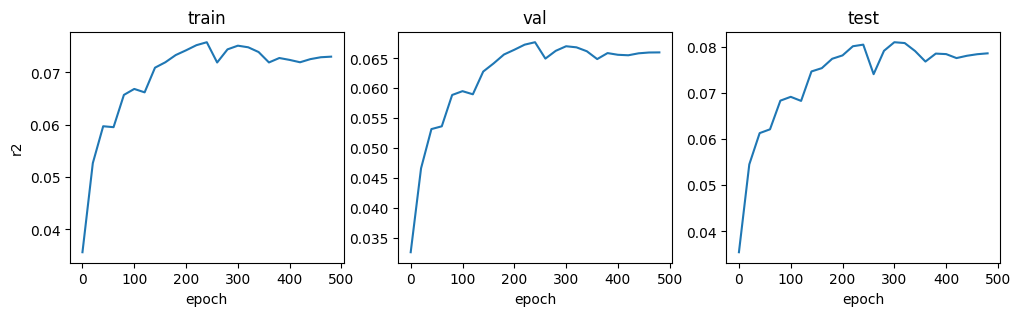

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['training'])
plt.xlabel('epoch')
plt.ylabel('r2')
plt.title('train')
plt.subplot(1,3,2)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['val'])
plt.xlabel('epoch')
plt.title('val')
plt.subplot(1,3,3)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) / len(history['training']))))], history['test'])
plt.xlabel('epoch')
plt.title('test')
plt.show()

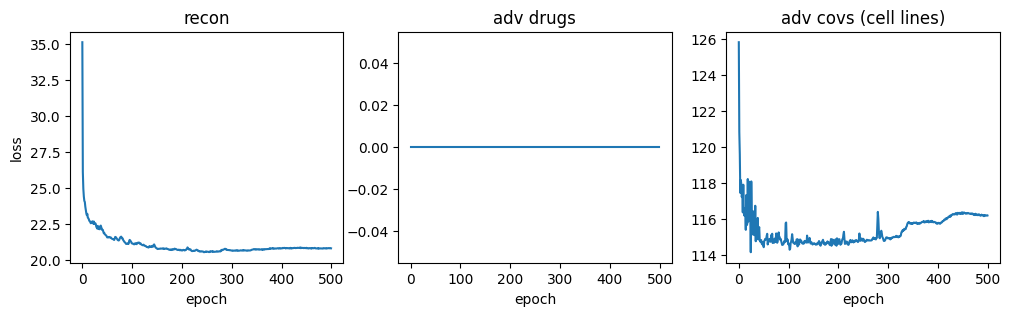

In [16]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(history['epoch'], history['loss_reconstruction'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('recon')
plt.subplot(1,3,2)
plt.plot(history['epoch'], history['loss_adv_drugs'])
plt.xlabel('epoch')
plt.title('adv drugs')
plt.subplot(1,3,3)
plt.plot(history['epoch'], history['loss_adv_covariates'])
plt.xlabel('epoch')
plt.title('adv covs (cell lines)')
plt.show()

### Sweep

#### (Transferred to script)

In [1]:
import torch, os
import pandas as pd
import numpy as np
from pathlib import Path
from pprint import pprint

from seml.config import generate_configs, read_config

from novelddi.chemcpa.chemCPA.experiments_run import TxAdaptingExperimentWrapper


In [ ]:
exp = TxAdaptingExperimentWrapper(init_all=False)

assert os.path.exists(
    "../../configs/chemcpa/chemcpa_tx_adapting_configs_sweep.yaml"
), "config file not found"
_, _, experiment_config = read_config(
    "../../configs/chemcpa/chemcpa_tx_adapting_configs_sweep.yaml"
)
# we take the first config generated
configs = generate_configs(experiment_config)
args = configs[0]
# pprint(args)

exp.init_dataset(**args["dataset"])
exp.init_drug_embedding(embedding=args["model"]["embedding"])

exp.init_model(
    hparams=args["model"]["hparams"],
    additional_params=args["model"]["additional_params"],
    load_pretrained=args["model"]["load_pretrained"],
    append_ae_layer=args["model"]["append_ae_layer"],
    pretrained_model_path=args["model"]["pretrained_model_path"],
    pretrained_model_ckpt=args["model"]["pretrained_model_ckpt"],
    use_drugs=args["model"]["use_drugs"]
)
exp.update_datasets()
all_res = [exp.train(**args["training"])]

for i in range(1, len(configs)):
    args = configs[i]
    exp.init_model(
        hparams=args["model"]["hparams"],
        additional_params=args["model"]["additional_params"],
        load_pretrained=args["model"]["load_pretrained"],
        append_ae_layer=args["model"]["append_ae_layer"],
        pretrained_model_path=args["model"]["pretrained_model_path"],
        pretrained_model_ckpt=args["model"]["pretrained_model_ckpt"],
        use_drugs=args["model"]["use_drugs"]
    )
    exp.update_datasets()
    all_res.append(exp.train(**args["training"]))

2023-09-01 09:08:19 (INFO): Starting to read in data from /n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/processed_data/views_features_new/tx/
...


#### Investigate sweep results

In [4]:
fnames = os.listdir('/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_output/pretrain/adapting/tx/checkpoints/sweep/')

In [8]:
def unpack_dict(dictionary):
    output = dict()
    for k, v in dictionary.items():
        if not isinstance(v, dict):
            output[k] = v
        else:
            temp = unpack_dict(v)
            output.update({k+'.'+kk : vv for kk, vv in temp.items()})
    return output
            
all_values = []
for fname in fnames:
    temp = torch.load(f'/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_output/pretrain/adapting/tx/checkpoints/sweep/{fname}')
    hparams = temp[3]
    inst = unpack_dict(hparams)
    inst['val_final'] = temp[4]['val'][-1]
    inst['test_final'] = temp[4]['test'][-1]
    all_values.append(inst)
all_sweep_values = pd.DataFrame(all_values)

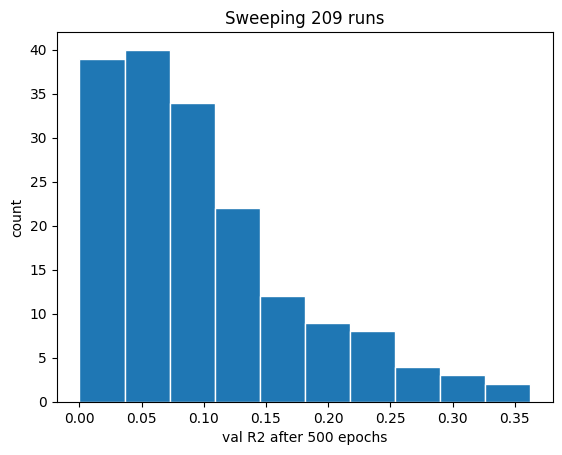

In [9]:
plt.hist(all_sweep_values['val_final'].values, ec='white', range=[0, all_sweep_values['val_final'].max()])
plt.xlabel('val R2 after 500 epochs')
plt.ylabel('count')
plt.title(f'Sweeping {all_sweep_values.shape[0]} runs')
plt.show()

In [198]:
len([col for col in all_sweep_values.columns if (col.startswith('hparams.') and col != 'hparams.dim') or col in {'use_drugs'}])

22

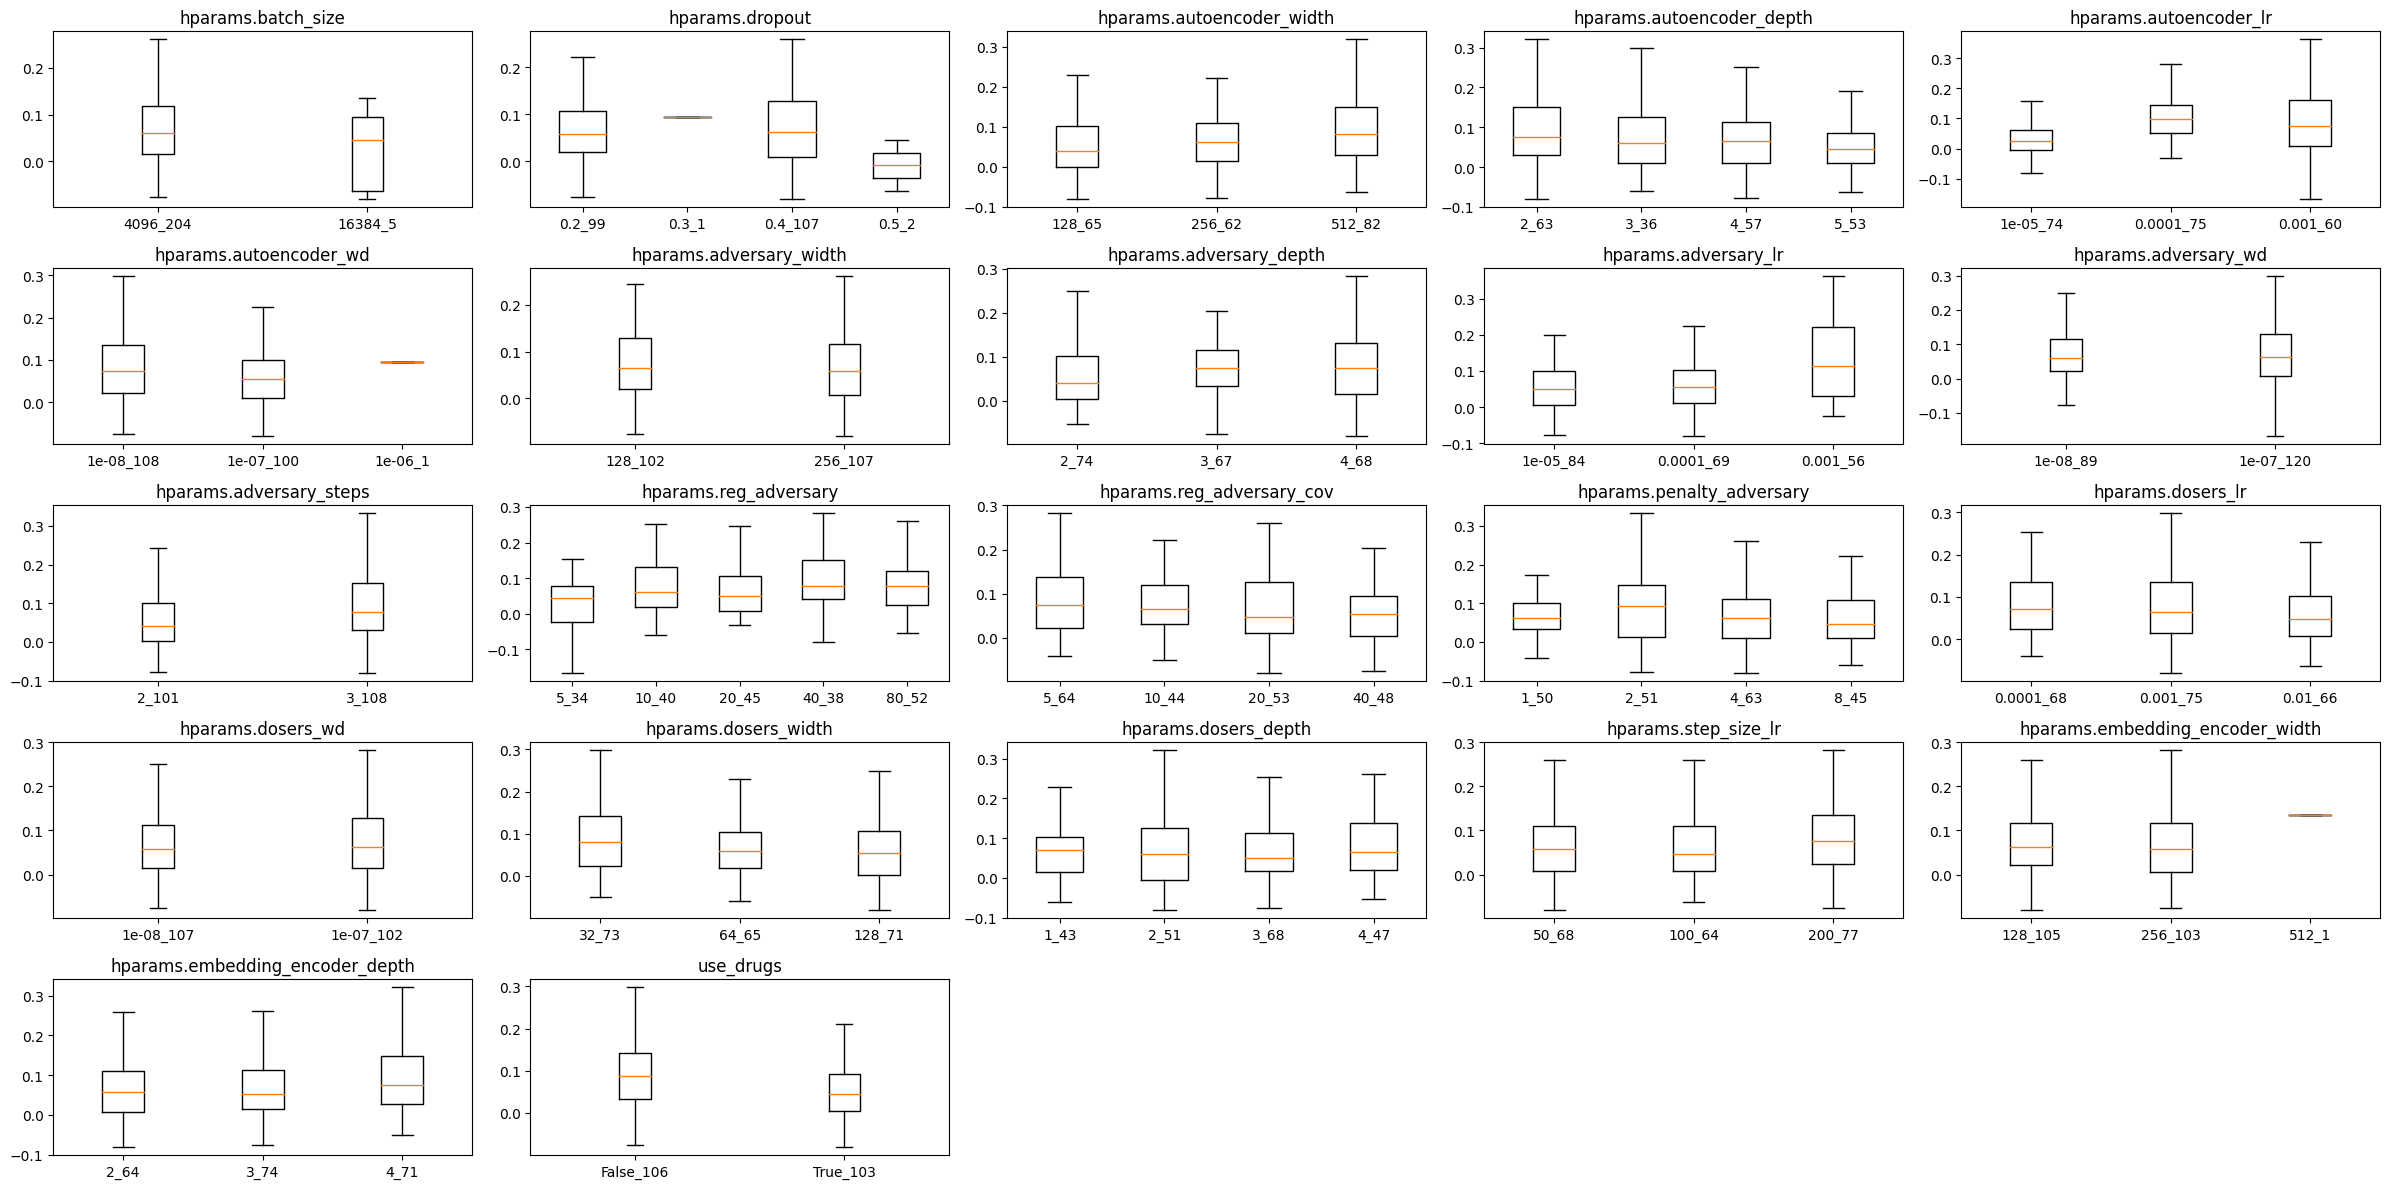

In [199]:
fig = plt.figure(figsize=(24, 12))
i = 1
for col in all_sweep_values.columns:
    if (col.startswith('hparams.') and col != 'hparams.dim') or col in {'use_drugs'}:
        ax = fig.add_subplot(5, 5, i)
        plot_data = all_sweep_values[[col, 'val_final']].groupby(col).agg(list)
        bp = ax.boxplot(plot_data['val_final'].values, showfliers=False, labels=[str(val)+'_'+str(len(plt_arr)) for val, plt_arr in zip(plot_data.index.values, plot_data['val_final'].values)])
        ax.set_title(f"{col}")
        i += 1
        
plt.tight_layout()
plt.show()

In [10]:
all_sweep_values['val_final'].argmax()

62

In [19]:
all_sweep_values.sort_values('val_final', ascending=False)['use_drugs'].head(20)

62     False
19     False
205    False
126    False
177    False
70     False
119    False
38     False
65     False
124    False
191    False
43      True
92     False
73     False
175    False
142     True
14     False
187    False
128    False
112     True
Name: use_drugs, dtype: bool

In [47]:
temp = torch.load(f'/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_output/pretrain/adapting/tx/checkpoints/sweep/{fnames[43]}')
history = temp[4]
temp[3]['use_drugs']

True

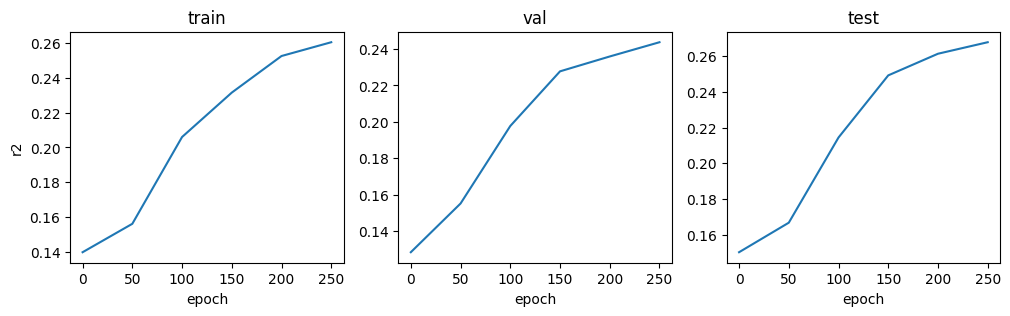

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['training'])
plt.xlabel('epoch')
plt.ylabel('r2')
plt.title('train')
plt.subplot(1,3,2)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['val'])
plt.xlabel('epoch')
plt.title('val')
plt.subplot(1,3,3)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) / len(history['training']))))], history['test'])
plt.xlabel('epoch')
plt.title('test')
plt.show()

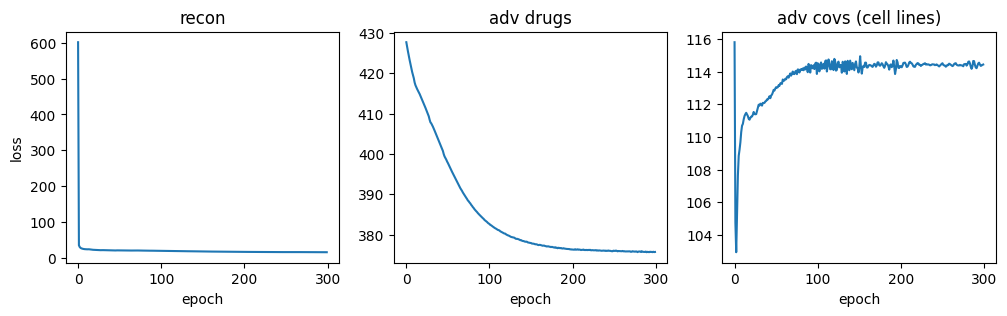

In [32]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(history['epoch'], history['loss_reconstruction'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('recon')
plt.subplot(1,3,2)
plt.plot(history['epoch'], history['loss_adv_drugs'])
plt.xlabel('epoch')
plt.title('adv drugs')
plt.subplot(1,3,3)
plt.plot(history['epoch'], history['loss_adv_covariates'])
plt.xlabel('epoch')
plt.title('adv covs (cell lines)')
plt.show()

#### Re-training best runs

In [56]:
exp = TxAdaptingExperimentWrapper(init_all=False)

assert os.path.exists(
    "/home/yeh803/workspace/DDI/NovelDDI/configs/chemcpa/chemcpa_tx_adapting_configs_sweep.yaml"
), "config file not found"
_, _, experiment_config = read_config(
    "/home/yeh803/workspace/DDI/NovelDDI/configs/chemcpa/chemcpa_tx_adapting_configs_sweep.yaml"
)
# we take the first config generated
configs = generate_configs(experiment_config)
args = configs[0]
args['training']['run_eval_disentangle'] = True

exp.init_dataset(**args["dataset"])
exp.init_drug_embedding(embedding=args["model"]["embedding"])

args["model"]["hparams"] = temp[3]["hparams"]
args["model"]["use_drugs"] = temp[3]["use_drugs"]
args["model"]["additional_params"]["decoder_activation"] = temp[3]["decoder_activation"]
exp.init_model(
    hparams=args["model"]["hparams"],
    additional_params=args["model"]["additional_params"],
    load_pretrained=args["model"]["load_pretrained"],
    append_ae_layer=args["model"]["append_ae_layer"],
    pretrained_model_path=args["model"]["pretrained_model_path"],
    pretrained_model_ckpt=args["model"]["pretrained_model_ckpt"],
    use_drugs=args["model"]["use_drugs"]
)
exp.update_datasets()

2023-09-05 12:04:04 (INFO): Starting to read in data from /n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/processed_data/views_features_new/tx/
...
2023-09-05 12:12:49 (INFO): Finished data loading.


In [57]:
exp.train(**args["training"])

CWD: /home/yeh803/workspace/DDI/NovelDDI/configs/chemcpa
Save dir: /n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_output/pretrain/adapting/tx/checkpoints/sweep/


2023-09-05 12:12:56 (INFO): 
{   'epoch': 0,
    'loss_adv_covariates': 2.6016295274098713,
    'loss_adv_drugs': 9.51290094587538,
    'loss_reconstruction': 0.973620265060001,
    'penalty_adv_covariates': 0.012651121088614067,
    'penalty_adv_drugs': 8.911340244611104}
2023-09-05 12:13:01 (INFO): 
{   'epoch': 1,
    'loss_adv_covariates': 2.5142112996843125,
    'loss_adv_drugs': 9.513118023342557,
    'loss_reconstruction': 0.7487144496705797,
    'penalty_adv_covariates': 0.0010923665094499787,
    'penalty_adv_drugs': 0.3286753793557485}
2023-09-05 12:13:06 (INFO): 
{   'epoch': 2,
    'loss_adv_covariates': 2.5043865203857423,
    'loss_adv_drugs': 9.513678402370877,
    'loss_reconstruction': 0.6690613243314955,
    'penalty_adv_covariates': 0.00022455148638174353,
    'penalty_adv_drugs': 0.7148472163412306}
2023-09-05 12:13:11 (INFO): 
{   'epoch': 3,
    'loss_adv_covariates': 2.5012842443254257,
    'loss_adv_drugs': 9.51002254486084,
    'loss_reconstruction': 0.62602006

Size of disentanglement testdata: 10506


2023-09-05 12:18:54 (INFO): Running R2 evaluation
2023-09-05 12:18:56 (INFO): 
{   'autoenc_early_stop': False,
    'ellapsed_minutes': 4.315011866887411,
    'epoch': 50,
    'evaluation_stats': {   'covariate disentanglement': [   0.9920997619628906],
                            'optimal for covariates': [   0.1326860785484314],
                            'optimal for perturbations': 0.01503902531886541,
                            'perturbation disentanglement': 0.997334897518158,
                            'test': 0.14611497521400452,
                            'training': 0.14028719067573547,
                            'val': 0.13266117870807648},
    'max_epochs_reached': False,
    'max_minutes_reached': False,
    'reconst_loss_is_nan': False,
    'test_score_is_nan': False}



Took 1.8 min for evaluation.



2023-09-05 12:19:00 (INFO): 
{   'epoch': 51,
    'loss_adv_covariates': 2.53269411722819,
    'loss_adv_drugs': 8.855199368794759,
    'loss_reconstruction': 0.4622231834464603,
    'penalty_adv_covariates': 7.042249308142345e-06,
    'penalty_adv_drugs': 0.09071608007782035}
2023-09-05 12:19:05 (INFO): 
{   'epoch': 52,
    'loss_adv_covariates': 2.5330915557013616,
    'loss_adv_drugs': 8.834928173489041,
    'loss_reconstruction': 0.4826007213857439,
    'penalty_adv_covariates': 6.566884157008543e-06,
    'penalty_adv_drugs': 0.886882330932551}
2023-09-05 12:19:10 (INFO): 
{   'epoch': 53,
    'loss_adv_covariates': 2.530775531133016,
    'loss_adv_drugs': 8.773279889424641,
    'loss_reconstruction': 0.46382116079330443,
    'penalty_adv_covariates': 6.907020098070562e-06,
    'penalty_adv_drugs': 50.64576316409641}
2023-09-05 12:19:14 (INFO): 
{   'epoch': 54,
    'loss_adv_covariates': 2.531032477484809,
    'loss_adv_drugs': 8.716457515292698,
    'loss_reconstruction': 0.4558

Size of disentanglement testdata: 10506


2023-09-05 12:24:22 (INFO): Running R2 evaluation
2023-09-05 12:24:24 (INFO): 
{   'autoenc_early_stop': False,
    'ellapsed_minutes': 9.79900232553482,
    'epoch': 100,
    'evaluation_stats': {   'covariate disentanglement': [   0.9879117012023926],
                            'optimal for covariates': [   0.1326860785484314],
                            'optimal for perturbations': 0.01503902531886541,
                            'perturbation disentanglement': 0.9976204037666321,
                            'test': 0.25768807530403137,
                            'training': 0.24594023823738098,
                            'val': 0.22648276388645172},
    'max_epochs_reached': False,
    'max_minutes_reached': False,
    'reconst_loss_is_nan': False,
    'test_score_is_nan': False}



Took 1.8 min for evaluation.



2023-09-05 12:24:29 (INFO): 
{   'epoch': 101,
    'loss_adv_covariates': 2.542961676915487,
    'loss_adv_drugs': 8.55952434539795,
    'loss_reconstruction': 0.38566043178240456,
    'penalty_adv_covariates': 9.73250547152323e-06,
    'penalty_adv_drugs': 2.9569263048892205e-11}
2023-09-05 12:24:33 (INFO): 
{   'epoch': 102,
    'loss_adv_covariates': 2.542623864279853,
    'loss_adv_drugs': 8.556756697760688,
    'loss_reconstruction': 0.3854050702518887,
    'penalty_adv_covariates': 1.1340354871612766e-05,
    'penalty_adv_drugs': 5.4874936462118776e-11}
2023-09-05 12:24:37 (INFO): 
{   'epoch': 103,
    'loss_adv_covariates': 2.5412826008266873,
    'loss_adv_drugs': 8.553888532850477,
    'loss_reconstruction': 0.38525612354278566,
    'penalty_adv_covariates': 8.831944230930983e-06,
    'penalty_adv_drugs': 2.855271626387188e-10}
2023-09-05 12:24:42 (INFO): 
{   'epoch': 104,
    'loss_adv_covariates': 2.541277286741469,
    'loss_adv_drugs': 8.552661556667752,
    'loss_recons

Size of disentanglement testdata: 10506


2023-09-05 12:30:01 (INFO): Running R2 evaluation
2023-09-05 12:30:03 (INFO): 
{   'autoenc_early_stop': False,
    'ellapsed_minutes': 15.449791264533996,
    'epoch': 150,
    'evaluation_stats': {   'covariate disentanglement': [   0.9910527467727661],
                            'optimal for covariates': [   0.1326860785484314],
                            'optimal for perturbations': 0.01503902531886541,
                            'perturbation disentanglement': 0.9939082860946655,
                            'test': 0.28330501914024353,
                            'training': 0.2702859938144684,
                            'val': 0.24569156765937805},
    'max_epochs_reached': False,
    'max_minutes_reached': False,
    'reconst_loss_is_nan': False,
    'test_score_is_nan': False}



Took 1.8 min for evaluation.



2023-09-05 12:30:08 (INFO): 
{   'epoch': 151,
    'loss_adv_covariates': 2.5384846210479735,
    'loss_adv_drugs': 8.470419269137912,
    'loss_reconstruction': 0.3672681318389045,
    'penalty_adv_covariates': 3.457219746552356e-06,
    'penalty_adv_drugs': 9.792790782133428e-07}
2023-09-05 12:30:12 (INFO): 
{   'epoch': 152,
    'loss_adv_covariates': 2.5370712757110594,
    'loss_adv_drugs': 8.47101559109158,
    'loss_reconstruction': 0.36602195501327517,
    'penalty_adv_covariates': 3.6363153412821703e-06,
    'penalty_adv_drugs': 8.6133098986036e-07}
2023-09-05 12:30:17 (INFO): 
{   'epoch': 153,
    'loss_adv_covariates': 2.539970053566827,
    'loss_adv_drugs': 8.468347062004938,
    'loss_reconstruction': 0.365510943863127,
    'penalty_adv_covariates': 2.6675866340358173e-06,
    'penalty_adv_drugs': 4.429480098464309e-07}
2023-09-05 12:30:21 (INFO): 
{   'epoch': 154,
    'loss_adv_covariates': 2.541712697347005,
    'loss_adv_drugs': 8.467713673909506,
    'loss_reconstru

Size of disentanglement testdata: 10506


2023-09-05 12:35:51 (INFO): Running R2 evaluation
2023-09-05 12:35:53 (INFO): 
{   'autoenc_early_stop': False,
    'ellapsed_minutes': 21.2340588927269,
    'epoch': 200,
    'evaluation_stats': {   'covariate disentanglement': [   0.992861270904541],
                            'optimal for covariates': [   0.1326860785484314],
                            'optimal for perturbations': 0.01503902531886541,
                            'perturbation disentanglement': 0.9960023164749146,
                            'test': 0.2948835790157318,
                            'training': 0.2811014652252197,
                            'val': 0.25691288709640503},
    'max_epochs_reached': False,
    'max_minutes_reached': False,
    'reconst_loss_is_nan': False,
    'test_score_is_nan': False}



Took 1.8 min for evaluation.



2023-09-05 12:35:57 (INFO): 
{   'epoch': 201,
    'loss_adv_covariates': 2.5452184677124023,
    'loss_adv_drugs': 8.40883043077257,
    'loss_reconstruction': 0.35309675335884094,
    'penalty_adv_covariates': 1.6774421763127774e-06,
    'penalty_adv_drugs': 0.0004652122834361055}
2023-09-05 12:36:02 (INFO): 
{   'epoch': 202,
    'loss_adv_covariates': 2.541915210088094,
    'loss_adv_drugs': 8.408662372165256,
    'loss_reconstruction': 0.35244954824447633,
    'penalty_adv_covariates': 1.5983434473633275e-06,
    'penalty_adv_drugs': 0.000418001419166103}
2023-09-05 12:36:06 (INFO): 
{   'epoch': 203,
    'loss_adv_covariates': 2.539738480250041,
    'loss_adv_drugs': 8.410085826449924,
    'loss_reconstruction': 0.35177694890234207,
    'penalty_adv_covariates': 1.2771104239719636e-06,
    'penalty_adv_drugs': 0.0006200345933191581}
2023-09-05 12:36:10 (INFO): 
{   'epoch': 204,
    'loss_adv_covariates': 2.538403383890788,
    'loss_adv_drugs': 8.410672611660427,
    'loss_recon

Size of disentanglement testdata: 10506


2023-09-05 12:41:46 (INFO): Running R2 evaluation
2023-09-05 12:41:48 (INFO): 
{   'autoenc_early_stop': False,
    'ellapsed_minutes': 27.165783349672953,
    'epoch': 250,
    'evaluation_stats': {   'covariate disentanglement': [   0.9947649240493774],
                            'optimal for covariates': [   0.1326860785484314],
                            'optimal for perturbations': 0.01503902531886541,
                            'perturbation disentanglement': 0.9920045733451843,
                            'test': 0.3058239817619324,
                            'training': 0.2913772165775299,
                            'val': 0.26276975870132446},
    'max_epochs_reached': False,
    'max_minutes_reached': False,
    'reconst_loss_is_nan': False,
    'test_score_is_nan': False}



Took 1.8 min for evaluation.



2023-09-05 12:41:52 (INFO): 
{   'epoch': 251,
    'loss_adv_covariates': 2.5395453453063963,
    'loss_adv_drugs': 8.409144740634494,
    'loss_reconstruction': 0.3471087740527259,
    'penalty_adv_covariates': 5.140719925596689e-07,
    'penalty_adv_drugs': 2.003972465500523e-08}
2023-09-05 12:41:57 (INFO): 
{   'epoch': 252,
    'loss_adv_covariates': 2.540757841534085,
    'loss_adv_drugs': 8.409370528327095,
    'loss_reconstruction': 0.3469797525140974,
    'penalty_adv_covariates': 5.539237286534949e-07,
    'penalty_adv_drugs': 3.387224738471417e-08}
2023-09-05 12:42:02 (INFO): 
{   'epoch': 253,
    'loss_adv_covariates': 2.540556859970093,
    'loss_adv_drugs': 8.408872646755642,
    'loss_reconstruction': 0.3464346918794844,
    'penalty_adv_covariates': 5.124490523182127e-07,
    'penalty_adv_drugs': 3.054031820030426e-08}
2023-09-05 12:42:07 (INFO): 
{   'epoch': 254,
    'loss_adv_covariates': 2.540401389863756,
    'loss_adv_drugs': 8.408214208814833,
    'loss_reconstru

Size of disentanglement testdata: 10506


2023-09-05 12:47:33 (INFO): Running R2 evaluation
2023-09-05 12:47:35 (INFO): 
{   'autoenc_early_stop': False,
    'ellapsed_minutes': 32.948371422290805,
    'epoch': 299,
    'evaluation_stats': {   'covariate disentanglement': [   0.9813439846038818],
                            'optimal for covariates': [   0.1326860785484314],
                            'optimal for perturbations': 0.01503902531886541,
                            'perturbation disentanglement': 0.991338312625885,
                            'test': 0.3048442602157593,
                            'training': 0.29051005840301514,
                            'val': 0.2609763443470001},
    'max_epochs_reached': True,
    'max_minutes_reached': False,
    'reconst_loss_is_nan': False,
    'test_score_is_nan': False}
2023-09-05 12:47:35 (INFO): Updating checkpoint at epoch 299
2023-09-05 12:47:35 (INFO): model_saved: 2023-09-05_12:12_tx_adapting_full_use_drugs_sweep.pt
2023-09-05 12:47:35 (INFO): early_stop: 299



Took 1.8 min for evaluation.



{'epoch': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  

In [ ]:
temp = torch.load(f'/n/data1/hms/dbmi/zitnik/lab/users/yeh803/DDI/model_output/pretrain/adapting/tx/checkpoints/2023-09-05_11:01_tx_adapting_full_use_drugs.pt')  # 2023-09-03_09:44_tx_adapting_full_test_not_use_drugs
history = temp[4]
temp[3]

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['training'])
plt.xlabel('epoch')
plt.ylabel('r2')
plt.title('train')
plt.subplot(1,3,2)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) // len(history['training']))))], history['val'])
plt.xlabel('epoch')
plt.title('val')
plt.subplot(1,3,3)
plt.plot(np.array(history['epoch'])[list(range(0, len(history['epoch']), int(len(history['epoch']) / len(history['training']))))], history['test'])
plt.xlabel('epoch')
plt.title('test')
plt.show()

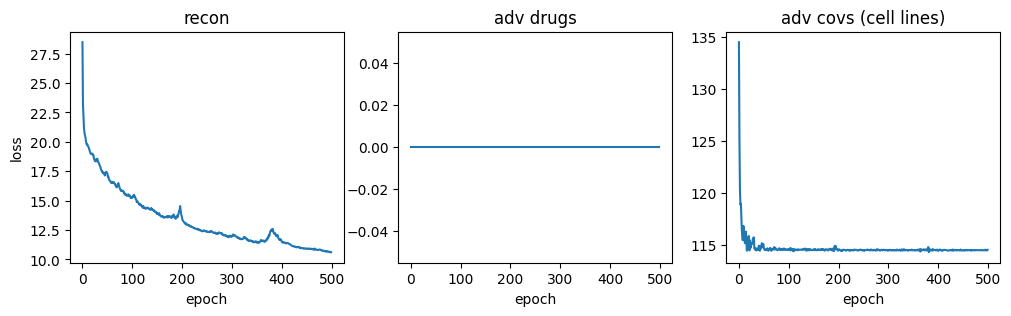

In [192]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(history['epoch'], history['loss_reconstruction'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('recon')
plt.subplot(1,3,2)
plt.plot(history['epoch'], history['loss_adv_drugs'])
plt.xlabel('epoch')
plt.title('adv drugs')
plt.subplot(1,3,3)
plt.plot(history['epoch'], history['loss_adv_covariates'])
plt.xlabel('epoch')
plt.title('adv covs (cell lines)')
plt.show()